In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import sys

sys.path.append("../")

from analysis.thesis_graphs.config import MODEL_NAME, MODEL_PLOT_ORDER, ABLATION_LABEL

In [2]:
tol_colors = [
    "#332288",  # dark blue
    "#117733",  # green
    "#44AA99",  # teal
    "#88CCEE",  # light blue
    "#DDCC77",  # sand
    "#CC6677",  # rose
    "#AA4499",  # purple
    "#882255",  # wine
]


tol_bright = [
    "#EE7733",  # orange
    "#0077BB",  # blue
    "#33BBEE",  # sky blue
    "#009988",  # teal
    "#CC3311",  # red
    "#EE3377",  # pink/magenta
    "#BBBBBB",  # gray
]

tol_muted = [
    "#CC6677",  # rose
    "#DDCC77",  # sand / mustard
    "#117733",  # green
    "#88CCEE",  # light blue
    "#332288",  # indigo
    "#AA4499",  # purple
    "#44AA99",  # teal
    "#999933",  # olive
    "#882255",  # wine
]


tol_warm_mix = [
    "#EE7733",  # warm orange
    "#CC6677",  # rose
    "#DDCC77",  # sand / mustard
    "#882255",  # wine
    "#117733",  # green (as cool accent)
    "#332288",  # indigo (as cool anchor)
]

tol_colors = tol_muted

In [16]:
exp_name = "subtitle_duration"  # "line_length_ratio"  #
base_path = f"../experiments/text/{exp_name}/artifacts/"
exp_df = pd.read_csv(f"{base_path}/experimental_data.csv")
exp_summary_df = pd.read_csv(f"{base_path}/experimental_data_summary.csv")
bayes_factor_df = pd.read_csv(f"{base_path}/{exp_name}_summary_factor_bayesian.csv")
seq_factor_df = pd.read_csv(f"{base_path}/{exp_name}_summary_factor_sequential.csv")
weber_factor_df = pd.read_csv(f"{base_path}/{exp_name}_summary_factor_weber.csv")
nrmse_df = pd.read_csv(f"{base_path}/{exp_name}_summary_nrmse_observed.csv")
# cue_com_df = pd.read_parquet(f"{base_path}/overall_cue_combo.parquet")
# cue_com_weights = pd.read_parquet(f"{base_path}/weights_global.parquet")
output_dir = f"../outputs/thesis/{exp_name}"
os.makedirs(output_dir, exist_ok=True)

color_dict = {
    "short": "#1f77b4",  # blue
    "medium": "#ff7f0e",  # orange
    "long": "#2ca02c",  # green
}

model_order = nrmse_df[
    (nrmse_df.ablation == "base") & (nrmse_df.modality == "text")
].sort_values("nrmse", ascending=True)["llm_model"]
model_names = model_order

In [4]:
# Base case plots
ablation = "base"

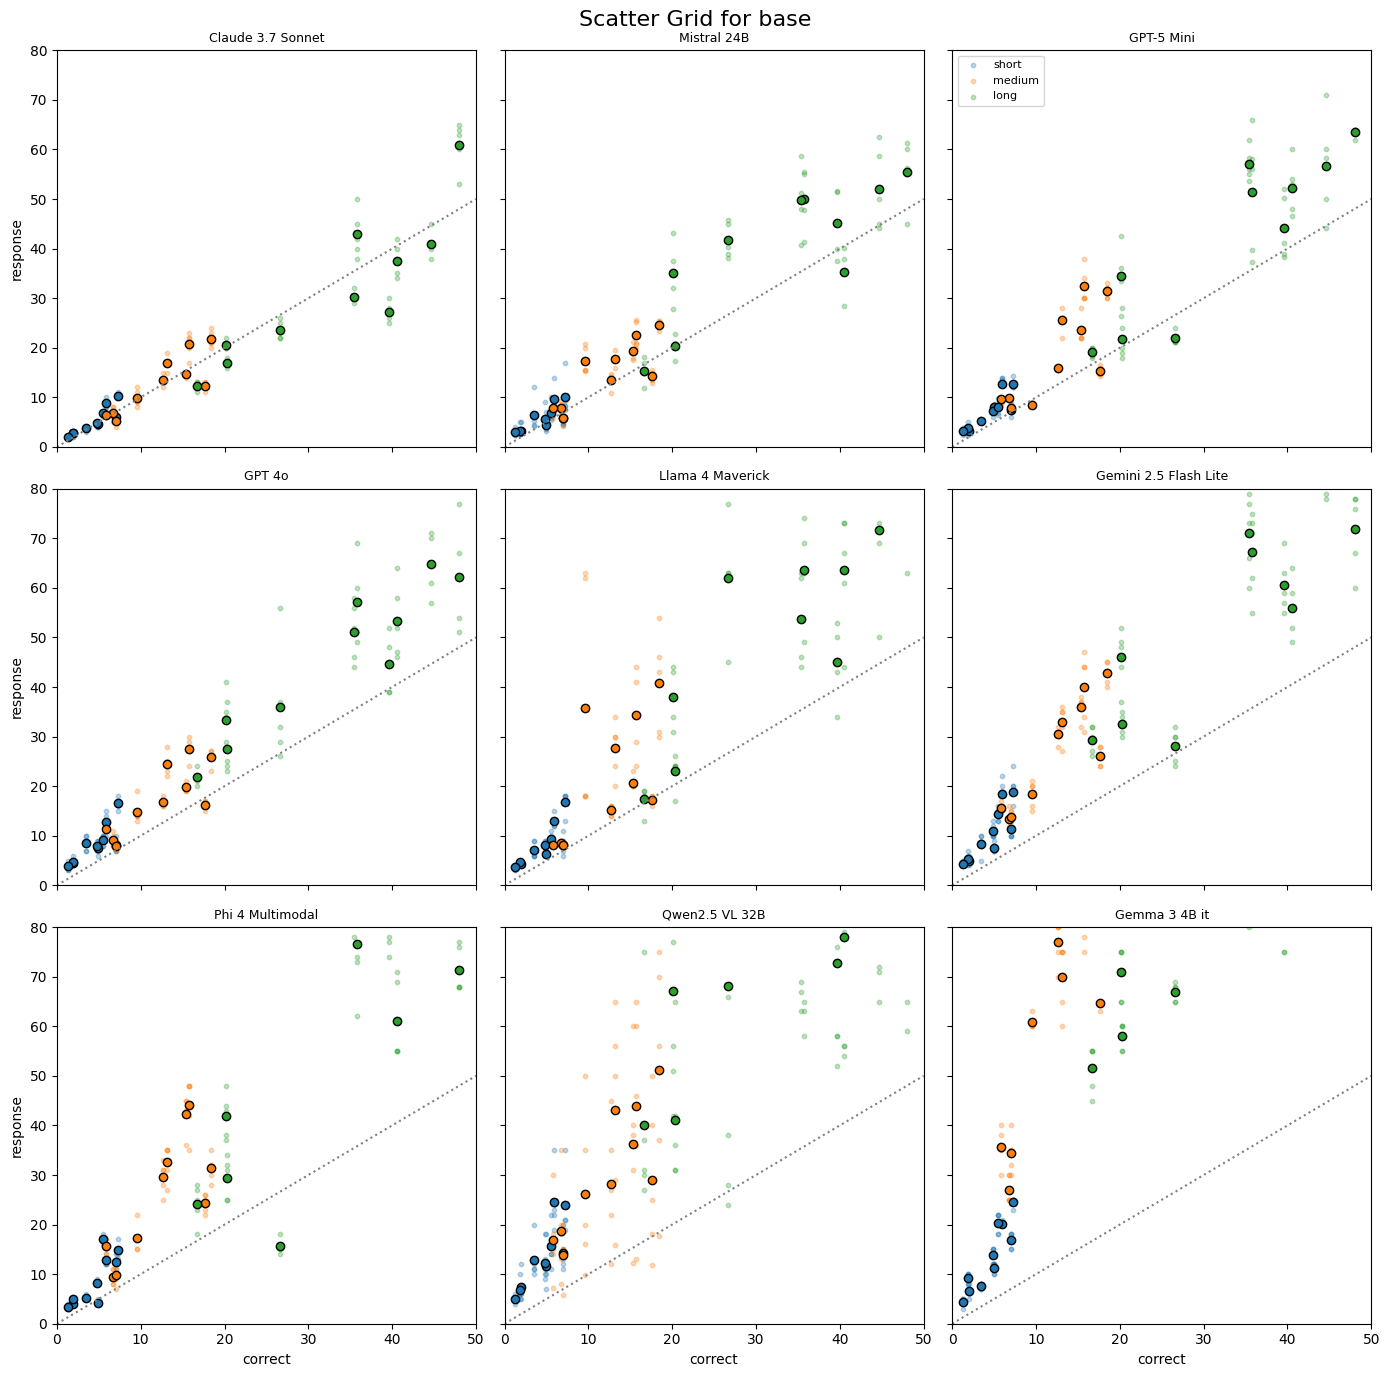

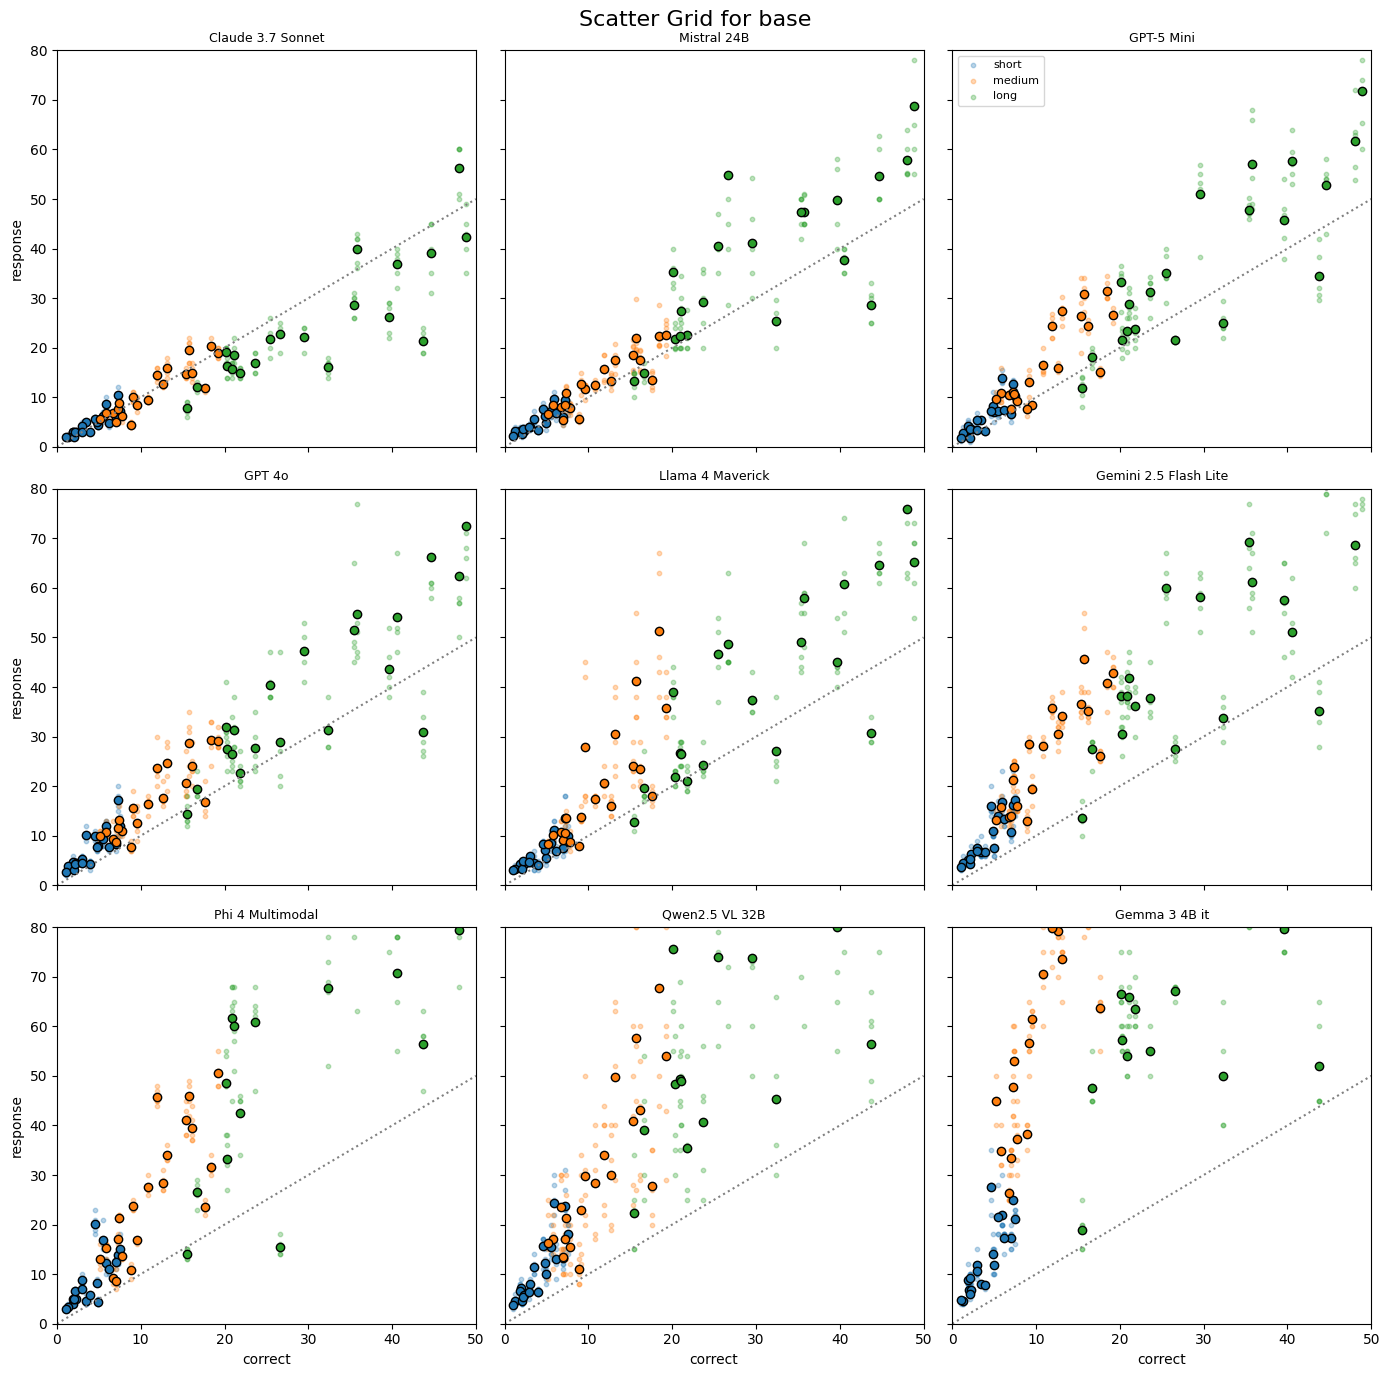

In [5]:
exp_list = ["base_text", "base_7_text"]
ablation_list = ["base", "base_7"]

# Scatter chart grid: one chart per model (no modalities)

for i, current_exp in enumerate(exp_list):
    current_exp = exp_list[i]
    current_ablation = ablation_list[i]
    fig, axes = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)

    fig.suptitle(
        f"Scatter Grid for {ablation}",
        fontsize=16,
        y=0.98,
    )  # Add this line

    for idx, llm in enumerate(model_names):
        ax = axes[idx // 3, idx % 3]
        df_sub = exp_df[
            (exp_df["llm_model"] == llm) & (exp_df["exp_id"] == current_exp)
        ]
        # Plot each range_category separately for fixed colors
        for cat, color in color_dict.items():
            df_cat = df_sub[df_sub["range_category"] == cat]
            ax.scatter(
                df_cat["correct"],
                df_cat["response"],
                alpha=0.3,
                s=10,
                label=cat,
                color=color,
            )
        # Optionally plot mean points if you want
        df_mean_sub = exp_summary_df[
            (exp_summary_df["llm_model"] == llm)
            & (exp_summary_df["exp_id"] == current_exp)
        ]
        for cat, color in color_dict.items():
            df_mean_cat = df_mean_sub[df_mean_sub["range_category"] == cat]
            ax.scatter(
                df_mean_cat["mean_correct"],
                df_mean_cat["mean_response"],
                alpha=1.0,
                edgecolors="black",
                label=None,
                color=color,
            )
        # Add 45-degree dotted line
        all_correct = pd.concat([df_sub["correct"], df_mean_sub["mean_correct"]])
        all_response = pd.concat([df_sub["response"], df_mean_sub["mean_response"]])
        min_val = 0  # min(all_correct.min(), all_response.min())
        max_val = 50  # max(all_correct.max() * 1.5) #, all_response.max())
        ax.plot([min_val, max_val], [min_val, max_val], ls=":", color="gray", zorder=1)
        ax.set_title(f"{MODEL_NAME[llm]}", fontsize=9)
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 80)
        if idx // 3 == 2:
            ax.set_xlabel("correct")
        if idx % 3 == 0:
            ax.set_ylabel("response")
        if idx == 2:
            ax.legend(loc="upper left", fontsize=8)

    plt.tight_layout()
    fig.savefig(
        f"{output_dir}/{current_ablation}_scatter_grid_models.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

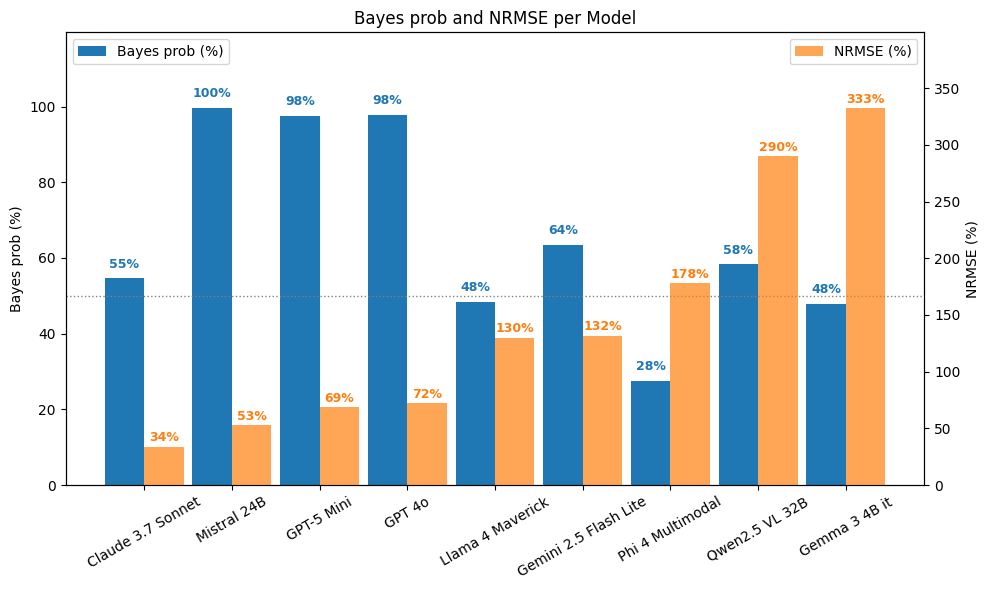

In [23]:
# Only show one row (no modalities)

model_order = list(model_names)  # Ensure model_names is a list in your notebook

fig, ax = plt.subplots(figsize=(10, 6))

# Use "text_image" or your desired modality, and ablation
modality = "text"
bayes_mod = bayes_factor_df[
    (bayes_factor_df["modality"] == modality)
    & (bayes_factor_df["ablation"] == ablation)
]
seq_mod = seq_factor_df[
    (seq_factor_df["modality"] == modality) & (seq_factor_df["ablation"] == ablation)
]
nrmse_mod = nrmse_df[
    (nrmse_df["modality"] == modality) & (nrmse_df["ablation"] == ablation)
]

bayes_mod = bayes_mod.set_index("llm_model").reindex(model_order)
nrmse_mod = nrmse_mod.set_index("llm_model").reindex(model_order)

x = np.arange(len(model_order))
width = 0.45

# Convert to percent for plotting
prob_bayes = bayes_mod["prob"].values * 100
nrmse_vals = nrmse_mod["nrmse"].values * 100

bars1 = ax.bar(
    x - width / 2, prob_bayes, width, label="Bayes prob (%)", color="#1f77b4"
)
ax2 = ax.twinx()
bars2 = ax2.bar(
    x + width / 2, nrmse_vals, width, label="NRMSE (%)", color="#ff7f0e", alpha=0.7
)

# Add dotted line at 50% for Bayes prob
ax.axhline(50, ls=":", color="gray", linewidth=1)

# Add percentage labels above Bayes prob bars
max_prob = np.nanmax(prob_bayes)
for idx, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#1f77b4",
        fontweight="bold",
    )

# Add percentage labels above NRMSE bars
max_nrmse = np.nanmax(nrmse_vals)
for idx, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#ff7f0e",
        fontweight="bold",
    )

ax.set_xticks(x)
ax.set_xticklabels([MODEL_NAME[m] for m in model_order], rotation=30)
ax.set_ylabel("Bayes prob (%)")
ax2.set_ylabel("NRMSE (%)")
ax.set_title("Bayes prob and NRMSE per Model")

# Set y-limits with extra space for labels
ax.set_ylim(0, max_prob * 1.2)
ax2.set_ylim(0, max_nrmse * 1.2)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
fig.savefig(f"{output_dir}/base_bayes_prob.pdf", dpi=300, bbox_inches="tight")

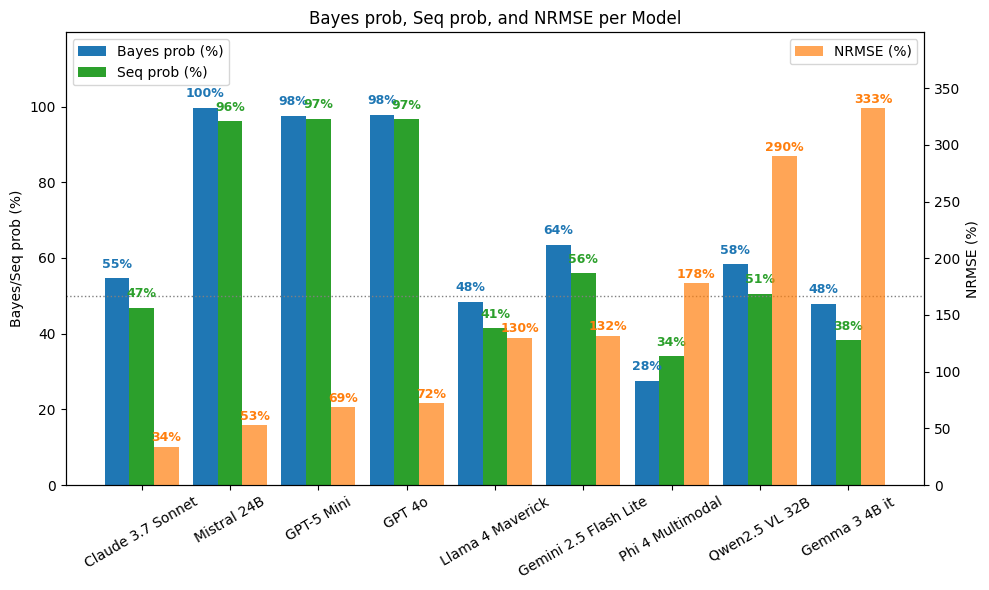

In [24]:
# ...existing code...

model_order = list(model_names)
fig, ax = plt.subplots(figsize=(10, 6))

modality = "text"
bayes_mod = bayes_factor_df[
    (bayes_factor_df["modality"] == modality)
    & (bayes_factor_df["ablation"] == ablation)
]
seq_mod = seq_factor_df[
    (seq_factor_df["modality"] == modality) & (seq_factor_df["ablation"] == ablation)
]
nrmse_mod = nrmse_df[
    (nrmse_df["modality"] == modality) & (nrmse_df["ablation"] == ablation)
]

bayes_mod = bayes_mod.set_index("llm_model").reindex(model_order)
seq_mod = seq_mod.set_index("llm_model").reindex(model_order)
nrmse_mod = nrmse_mod.set_index("llm_model").reindex(model_order)

x = np.arange(len(model_order))
width = 0.28

prob_bayes = bayes_mod["prob"].values * 100
prob_seq = seq_mod["prob"].values * 100
nrmse_vals = nrmse_mod["nrmse"].values * 100

bars1 = ax.bar(x - width, prob_bayes, width, label="Bayes prob (%)", color="#1f77b4")
bars2 = ax.bar(x, prob_seq, width, label="Seq prob (%)", color="#2ca02c")

ax2 = ax.twinx()
bars3 = ax2.bar(
    x + width, nrmse_vals, width, label="NRMSE (%)", color="#ff7f0e", alpha=0.7
)

ax.axhline(50, ls=":", color="gray", linewidth=1)

max_prob = np.nanmax([prob_bayes, prob_seq])
max_nrmse = np.nanmax(nrmse_vals)

for idx, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#1f77b4",
        fontweight="bold",
    )
for idx, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#2ca02c",
        fontweight="bold",
    )
for idx, bar in enumerate(bars3):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#ff7f0e",
        fontweight="bold",
    )

ax.set_xticks(x)
ax.set_xticklabels([MODEL_NAME[m] for m in model_order], rotation=30)
ax.set_ylabel("Bayes/Seq prob (%)")
ax2.set_ylabel("NRMSE (%)")
ax.set_title("Bayes prob, Seq prob, and NRMSE per Model")

ax.set_ylim(0, max_prob * 1.2)
ax2.set_ylim(0, max_nrmse * 1.2)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
fig.savefig(f"{output_dir}/base_bayes_seq_nrmse_prob.pdf", dpi=300, bbox_inches="tight")
plt.show()
# ...existing code...

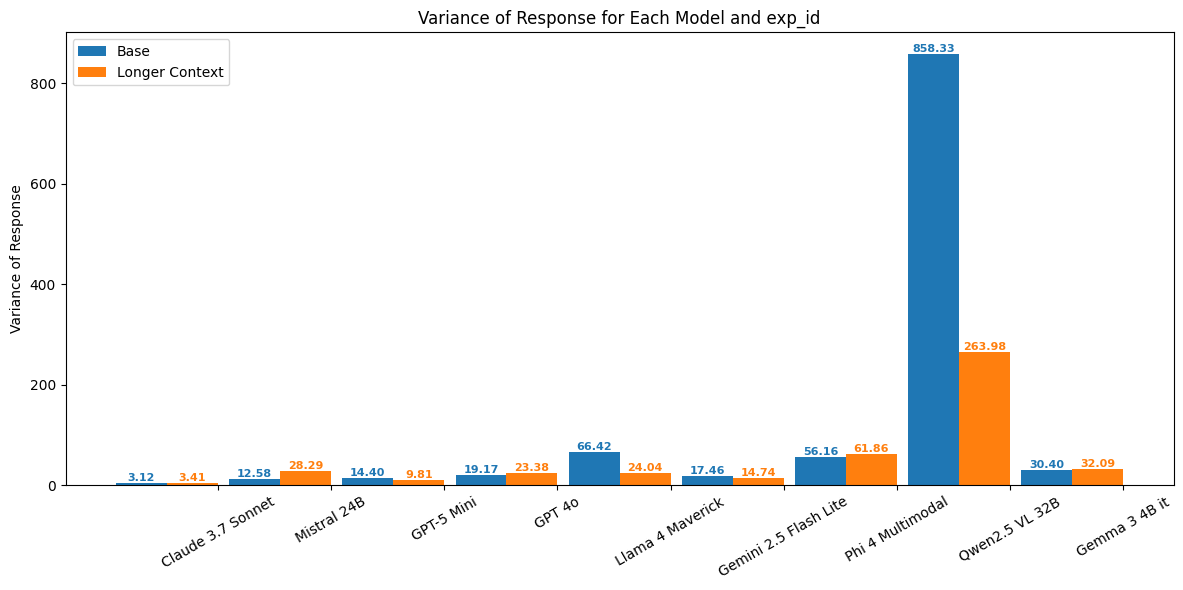

In [7]:
# Clustered bar chart: variance of response for each model and exp_id

exp_ids = [
    "base_text",
    "base_7_text",
]

x = np.arange(len(model_order))
width = 0.45  # bar width

# Prepare variance data for each exp_id and model
var_response_vals = []
for exp_id in exp_ids:
    # Average variance per model for each exp_id
    df_sub = exp_summary_df[exp_summary_df["exp_id"] == exp_id]
    grouped = df_sub.groupby("llm_model")["var_response"].mean().reindex(model_order)
    var_response_vals.append(grouped.values)

bar_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
bar_labels = ["Base", "Longer Context"]


fig, ax = plt.subplots(figsize=(12, 6))
bar_max = 0

for i, (vals, label, color) in enumerate(
    zip(var_response_vals, bar_labels, bar_colors)
):
    bars = ax.bar(x + (i - 1.5) * width, vals, width, label=label, color=color)
    for bar in bars:
        height = bar.get_height()
        bar_max = max(bar_max, height)
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color=color,
            fontweight="bold",
        )


# ax.set_ylim(0, min(2, bar_max))
ax.set_ylabel("Variance of Response")
ax.set_title("Variance of Response for Each Model and exp_id")
ax.set_xticks(x)
ax.set_xticklabels([MODEL_NAME[m] for m in model_order], rotation=30)
ax.legend(loc="upper left", fontsize=10)

plt.tight_layout()
fig.savefig(
    f"{output_dir}/cue_variance_clustered_bar.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [8]:
# Noise related ablations
exp_ids = ["base", "base_7"]

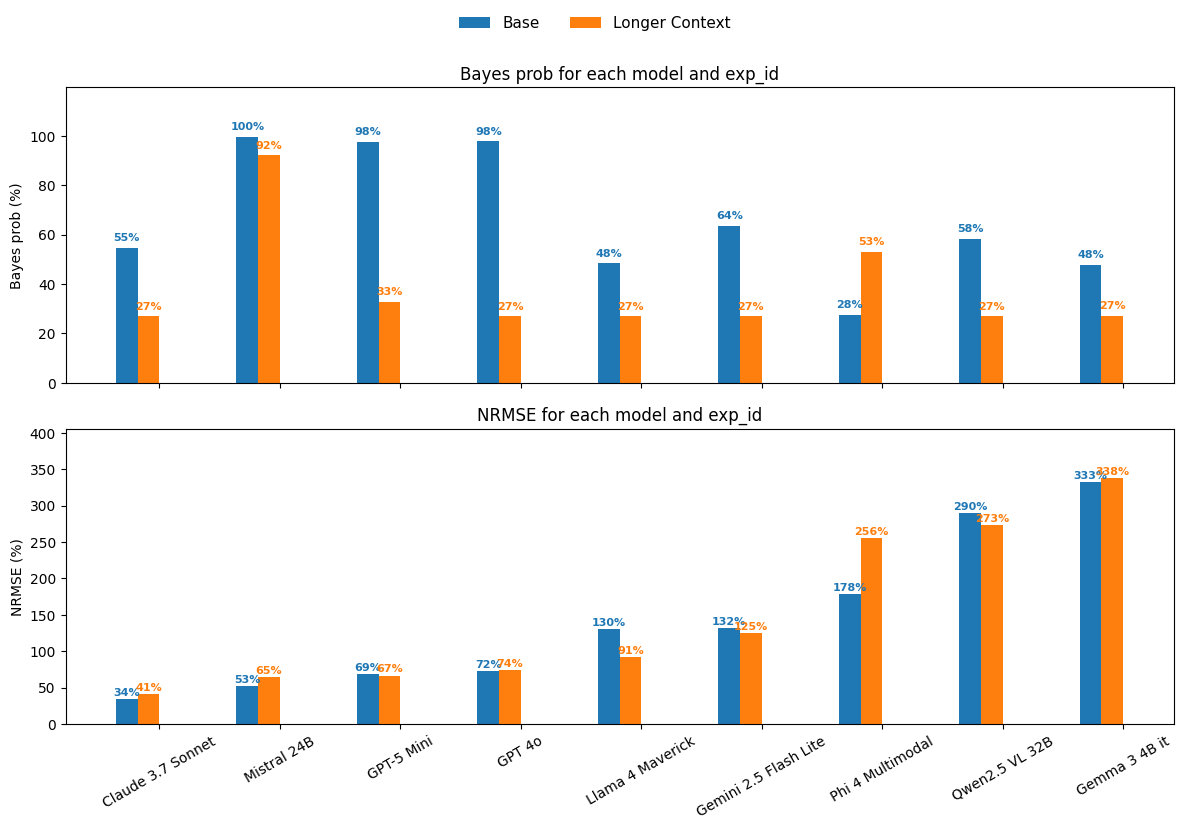

In [9]:
# ...existing code...
model_order = list(model_names)
x = np.arange(len(model_order))
width = 0.18  # bar width

# Prepare Bayes prob and NRMSE data for each exp_id and model
bayes_probs = []
nrmse_vals = []
for exp_id in exp_ids:
    bayes_mod = (
        bayes_factor_df[
            (bayes_factor_df["modality"] == "text")
            & (bayes_factor_df["ablation"] == exp_id)
        ]
        .set_index("llm_model")
        .reindex(model_order)
    )
    nrmse_mod = (
        nrmse_df[(nrmse_df["modality"] == "text") & (nrmse_df["ablation"] == exp_id)]
        .set_index("llm_model")
        .reindex(model_order)
    )
    bayes_probs.append(bayes_mod["prob"].values * 100)
    nrmse_vals.append(nrmse_mod["nrmse"].values * 100)

# Colors and labels for each exp_id
bar_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
# bar_colors =
bar_labels = ["Base", "Longer Context"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Chart 1: Bayes prob ---
ax = axes[0]
for i, (vals, label, color) in enumerate(zip(bayes_probs, bar_labels, bar_colors)):
    bars = ax.bar(x + (i - 1.5) * width, vals, width, label=label, color=color)
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f"{height:.0f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=color,
            fontweight="bold",
        )
ax.set_ylabel("Bayes prob (%)")
ax.set_title("Bayes prob for each model and exp_id")
ax.set_ylim(0, np.nanmax(bayes_probs) * 1.2)

# --- Chart 2: NRMSE ---
ax = axes[1]
nrmse_labels = [label.replace("Bayes prob", "NRMSE") for label in bar_labels]
for i, (vals, label, color) in enumerate(zip(nrmse_vals, nrmse_labels, bar_colors)):
    bars = ax.bar(x + (i - 1.5) * width, vals, width, label=label, color=color)
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f"{height:.0f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=color,
            fontweight="bold",
        )
ax.set_ylabel("NRMSE (%)")
ax.set_title("NRMSE for each model and exp_id")
ax.set_ylim(0, np.nanmax(nrmse_vals) * 1.2)

axes[1].set_xticks(x)
axes[1].set_xticklabels([MODEL_NAME[m] for m in model_order], rotation=30)

# Legend at top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.04),
    frameon=False,
    fontsize=11,
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f"{output_dir}/context_bayes_prob.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
# Scoring

In [11]:
nrmse_df["min_nrmse"] = nrmse_df.groupby("llm_model")["nrmse"].transform("min")
nrmse_df["nrmse_pct_of_min"] = nrmse_df["nrmse"] / nrmse_df["min_nrmse"] * 100
nrmse_df["nrmse_delta_to_min"] = nrmse_df["nrmse"] - nrmse_df["min_nrmse"]

/var/folders/zy/f29cfj3n6s74jwqsbwmjd8yc0000gn/T/ipykernel_96677/3416523346.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(max_pct_df["model_label"], rotation=30)


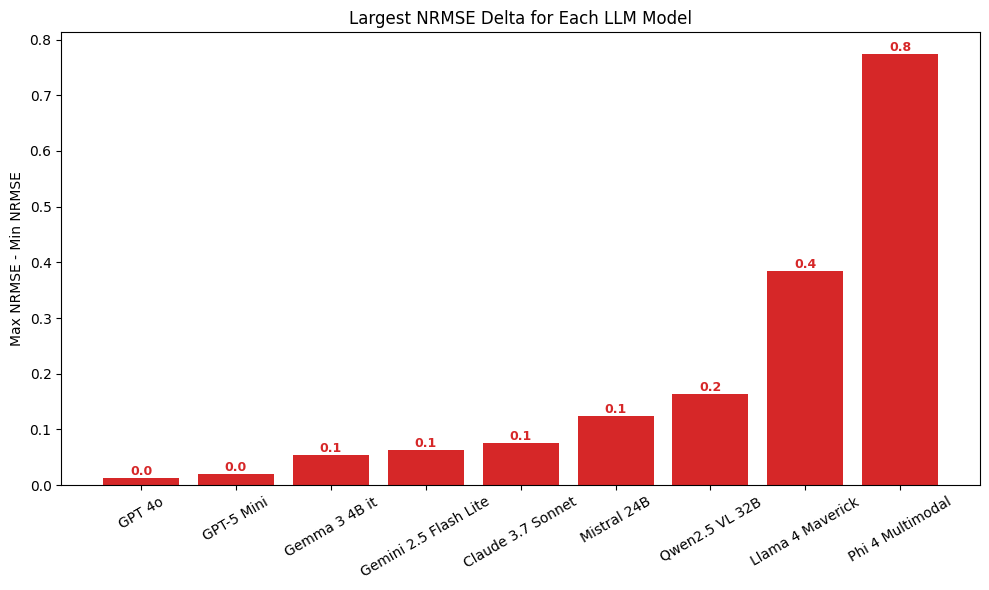

In [12]:
# Get max % for each llm_model
max_pct_df = nrmse_df.groupby("llm_model")["nrmse_delta_to_min"].max().reset_index()
max_pct_df["model_label"] = max_pct_df["llm_model"].map(MODEL_NAME)

# Sort by value
max_pct_df = max_pct_df.sort_values("nrmse_delta_to_min")
max_pct_df = max_pct_df[max_pct_df["llm_model"].isin(model_names)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    max_pct_df["model_label"], max_pct_df["nrmse_delta_to_min"], color="#d62728"
)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,  # + 2,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#d62728",
        fontweight="bold",
    )

ax.set_ylabel("Max NRMSE - Min NRMSE")
ax.set_title("Largest NRMSE Delta for Each LLM Model")
ax.set_xticklabels(max_pct_df["model_label"], rotation=30)
plt.tight_layout()
plt.savefig(f"{output_dir}/max_nrmse_delta_to_min.png", dpi=300, bbox_inches="tight")
plt.show()

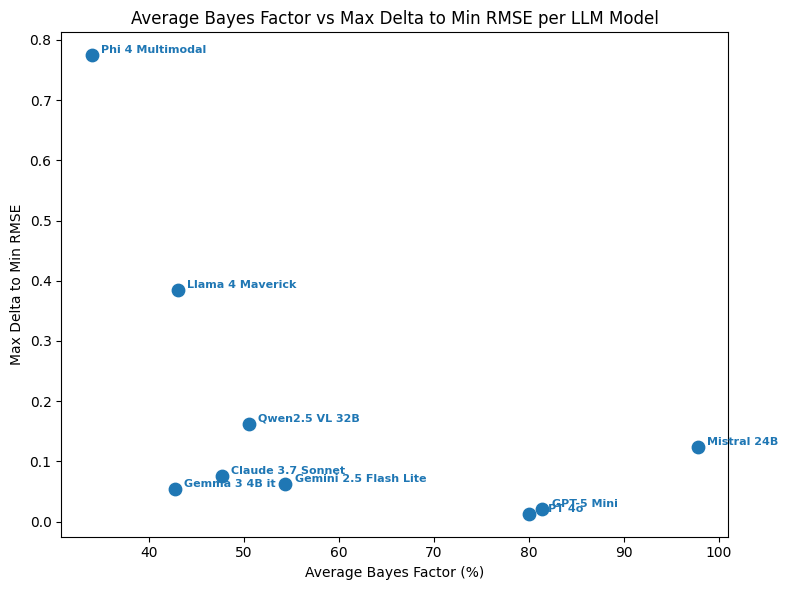

In [13]:
# Scatter plot: average Bayes factor (prob) vs max delta to min RMSE for each llm_model

# Compute max delta to min RMSE for each llm_model
max_delta_df = nrmse_df.groupby("llm_model")["nrmse_delta_to_min"].max().reset_index()
max_delta_df["model_label"] = max_delta_df["llm_model"].map(MODEL_NAME)

# Compute average Bayes factor (prob) for each llm_model
avg_bayes_df = bayes_factor_df.groupby("llm_model")["prob"].mean().reset_index()
avg_bayes_df["model_label"] = avg_bayes_df["llm_model"].map(MODEL_NAME)

scatter_df = pd.merge(max_delta_df, avg_bayes_df, on="llm_model")
scatter_df["model_label"] = scatter_df["llm_model"].map(MODEL_NAME)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    scatter_df["prob"] * 100, scatter_df["nrmse_delta_to_min"], color="#1f77b4", s=80
)

for i, row in scatter_df.iterrows():
    ax.text(
        row["prob"] * 100 + 1,
        row["nrmse_delta_to_min"],  # + 0.5,
        row["model_label"],
        fontsize=8,
        ha="left",
        va="bottom",
        color="#1f77b4",
        fontweight="bold",
    )

ax.set_xlabel("Average Bayes Factor (%)")
ax.set_ylabel("Max Delta to Min RMSE")
ax.set_title("Average Bayes Factor vs Max Delta to Min RMSE per LLM Model")
plt.tight_layout()
plt.savefig(f"{output_dir}/bayes_vs_max_delta.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/zy/f29cfj3n6s74jwqsbwmjd8yc0000gn/T/ipykernel_96677/3470818292.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_bayes_df["model_label"], rotation=30)


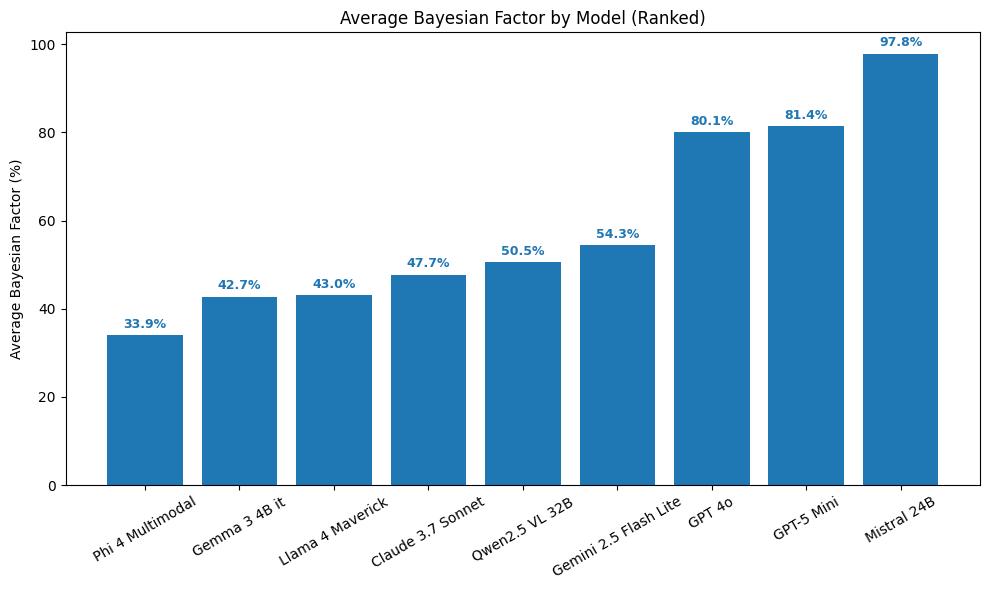

In [14]:
# Bar chart: Average Bayesian factor (prob) by model, ranked from small to high

# Compute average Bayesian factor for each model
avg_bayes_df = bayes_factor_df.groupby("llm_model")["prob"].mean().reset_index()
avg_bayes_df = avg_bayes_df[avg_bayes_df["llm_model"].isin(model_names)]
avg_bayes_df["model_label"] = avg_bayes_df["llm_model"].map(MODEL_NAME)

# Sort by average Bayesian factor
avg_bayes_df = avg_bayes_df.sort_values("prob")

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(avg_bayes_df["model_label"], avg_bayes_df["prob"] * 100, color="#1f77b4")
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#1f77b4",
        fontweight="bold",
    )

ax.set_ylabel("Average Bayesian Factor (%)")
ax.set_title("Average Bayesian Factor by Model (Ranked)")
ax.set_xticklabels(avg_bayes_df["model_label"], rotation=30)
plt.tight_layout()
fig.savefig(f"{output_dir}/avg_bayes_factor_ranked.png", dpi=300, bbox_inches="tight")
plt.show()

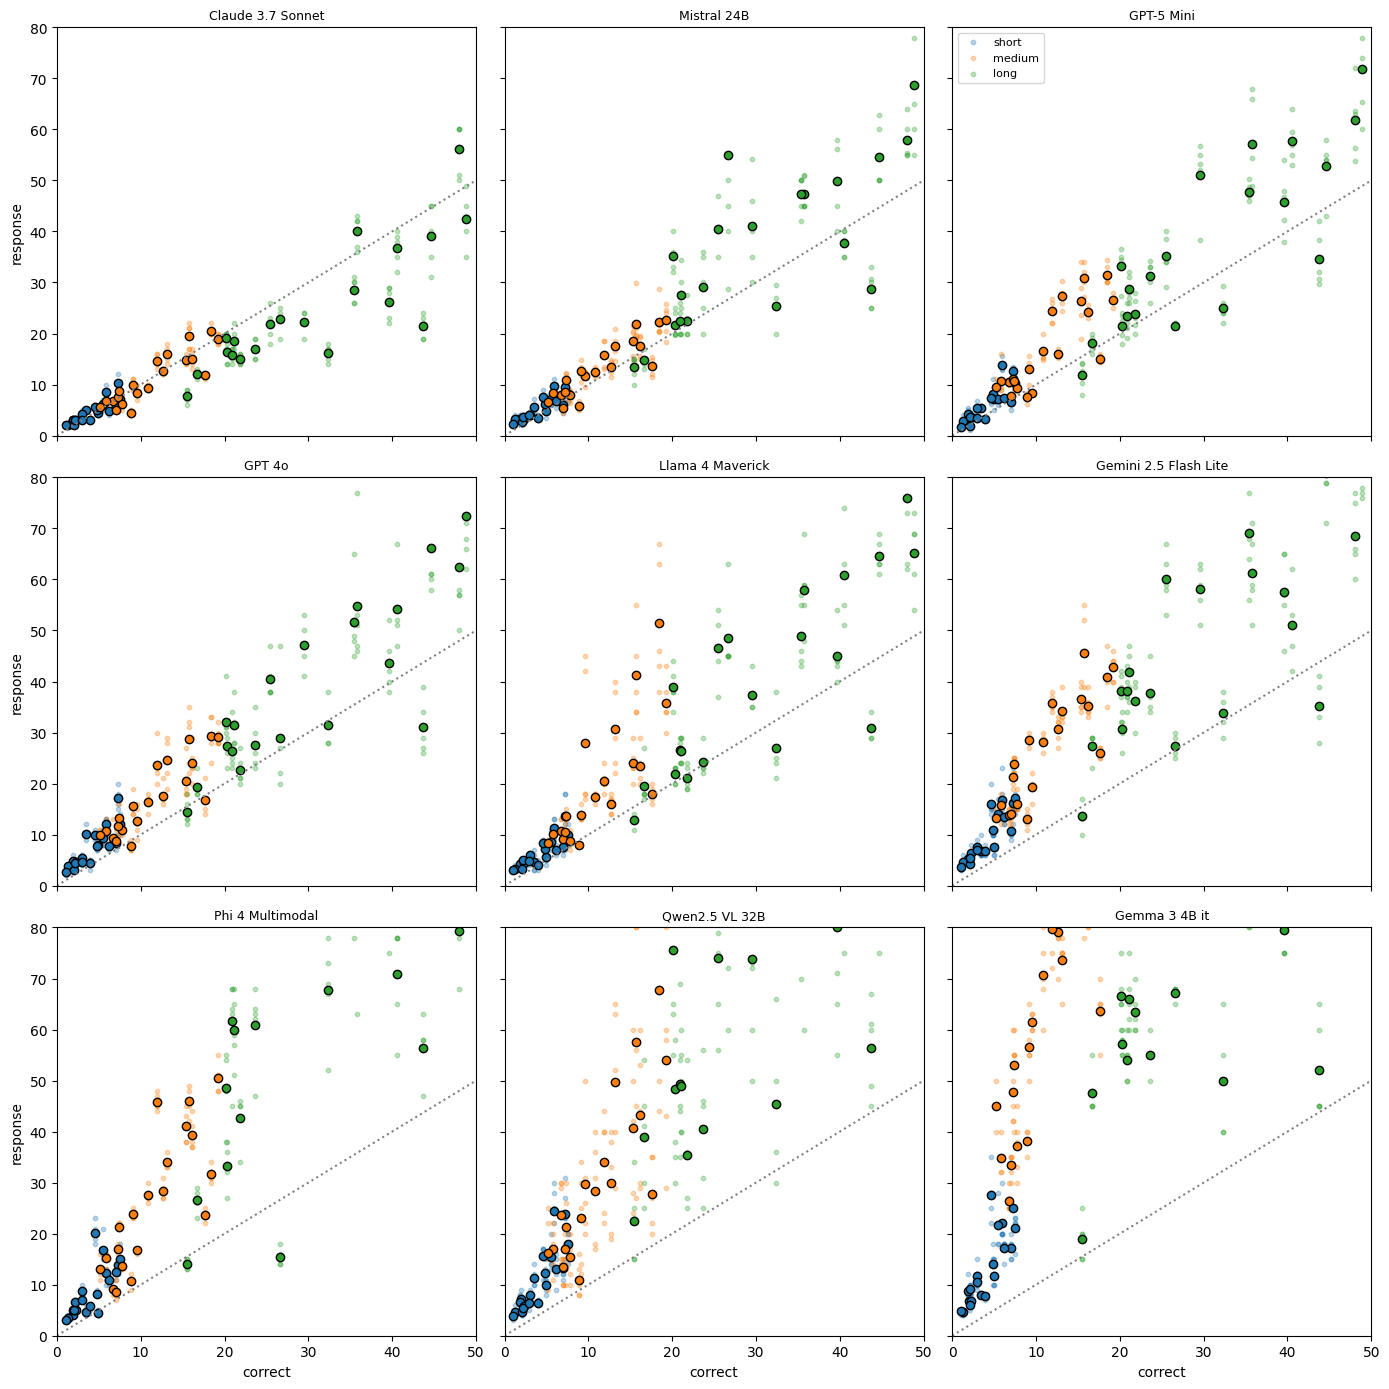

In [15]:
# Scatter chart grid: one chart per model (no modalities)

fig, axes = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
current_exp = "base_7_text"

for idx, llm in enumerate(model_names):
    ax = axes[idx // 3, idx % 3]
    df_sub = exp_df[(exp_df["llm_model"] == llm) & (exp_df["exp_id"] == current_exp)]
    # Plot each range_category separately for fixed colors
    for cat, color in color_dict.items():
        df_cat = df_sub[df_sub["range_category"] == cat]
        ax.scatter(
            df_cat["correct"],
            df_cat["response"],
            alpha=0.3,
            s=10,
            label=cat,
            color=color,
        )
    # Optionally plot mean points if you want
    df_mean_sub = exp_summary_df[
        (exp_summary_df["llm_model"] == llm) & (exp_summary_df["exp_id"] == current_exp)
    ]
    for cat, color in color_dict.items():
        df_mean_cat = df_mean_sub[df_mean_sub["range_category"] == cat]
        ax.scatter(
            df_mean_cat["mean_correct"],
            df_mean_cat["mean_response"],
            alpha=1.0,
            edgecolors="black",
            label=None,
            color=color,
        )
    # Add 45-degree dotted line
    all_correct = pd.concat([df_sub["correct"], df_mean_sub["mean_correct"]])
    all_response = pd.concat([df_sub["response"], df_mean_sub["mean_response"]])
    min_val = 0  # min(all_correct.min(), all_response.min())
    max_val = 50  # max(all_correct.max() * 1.5) #, all_response.max())
    ax.plot([min_val, max_val], [min_val, max_val], ls=":", color="gray", zorder=1)
    ax.set_title(f"{MODEL_NAME[llm]}", fontsize=9)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 80)
    if idx // 3 == 2:
        ax.set_xlabel("correct")
    if idx % 3 == 0:
        ax.set_ylabel("response")
    if idx == 2:
        ax.legend(loc="upper left", fontsize=8)

plt.tight_layout()
fig.savefig(f"{output_dir}/scatter_grid_models.pdf", dpi=300, bbox_inches="tight")
plt.show()